# Keras Fully Convolutional Network

First try to train a fcn to play Dots and Boxes.

## Data

We have grayscale images as input and output. The input images shows all dots, lines and boxes while the output image only shows the line the hard AI in KSquares would choose. For this first try there are 10,000 examples of 5x4 games that are in the "interesting" phase of the game. For a more detailed description of how this data was generated, have a look at the "convertDataset" directory.

Input: ![input image data](input.png) Output: ![output image data](output.png)

In [1]:
import numpy as np
import tensorflow as tf
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.utils.np_utils import to_categorical
from keras.utils import plot_model
import keras.backend as K
from PIL import Image
from matplotlib.pyplot import imshow
%matplotlib inline
import random

Using TensorFlow backend.


In [2]:
print(K.image_data_format())

channels_last


## Build Keras Model

For this first try we use 6 convolutional layers with 64 filters, combined with relu activation. We do batch normalization after each layer.
We want to use categorical crossentropy as the loss function, which expects our output to be in one-hot encoding. There are two classes: "line" and "no line". Thus our last layer reduces the output to two channels. The last layer uses softmax activation for two reasons: 

1. the loss function expects the softmax output
2. a probability distribution over the possible actions fits our needs quite well

Since the model is a fully convolutional network it is not bound to a specific input size. That's pretty useful because Dots and Boxes is not bound to be played on a particularly sized board. It's a key improvement over the network used in QDab.

![firstTry model architecture](firstTry_architecture.png)

In [3]:
#img_input = Input(shape=(11,13,1,))
img_input = Input(shape=(None,None,1,))
x = Conv2D(64, (3,3), padding='same', activation='relu')(img_input)
x = BatchNormalization()(x)
x = Conv2D(64, (3,3), padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3,3), padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3,3), padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3,3), padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3,3), padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = Conv2D(2, (3,3), padding='same', activation='softmax')(x)

model = Model(inputs=img_input, outputs=x)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 1)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 64)    640       
_________________________________________________________________
batch_normalization_1 (Batch (None, None, None, 64)    256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 64)    36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, None, None, 64)    256       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, None, None, 64)    36928     
_________________________________________________________________
batch_normalization_3 (Batch (None, None, None, 64)    256       
__________

In [4]:
model.compile(optimizer='sgd', loss='categorical_crossentropy')

## Load the dataset
The dataset has been created with the convertDataset.py file. It contains two numpy arrays with grayscale images, using 8 bits per pixel. 

Here, the dataset is converted to match the network's requirements by converting it to floating point data and by normalizing the data to be in the range from 0 to 1. Furthermore the target array is converted to the one-hot format. 

In [5]:
firstTryDataset = np.load('firstTry.npz')
x_train = firstTryDataset['x_train']
y_train = firstTryDataset['y_train']

print("original data:")
print(x_train[0])
print(y_train[0])
print(x_train.shape)
print(y_train.shape)


print("\nnormalized data:")
sp = x_train.shape
x_train = x_train.reshape((sp[0],sp[1],sp[2],1))
sp = y_train.shape
y_train = y_train.reshape((sp[0],sp[1],sp[2],1))

x_train = x_train.astype(K.floatx())
y_train = y_train.astype(K.floatx())
#x_train = np.true_divide(x_train,255.0)
x_train /= 255
y_train /= 255

np.set_printoptions(precision=2)
print(np.transpose(x_train[0]))
print(np.transpose(y_train[0]))
print(x_train.shape)
print(y_train.shape)

original data:
[[  0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0 215 255 215 255 215 255 215 255 215 255 215   0]
 [  0 255   0   0   0   0   0   0   0   0   0   0   0]
 [  0 215   0 215 255 215 255 215 255 215 255 215   0]
 [  0   0   0 255   0   0   0 255   0   0   0 255   0]
 [  0 215 255 215   0 215   0 215   0 215   0 215   0]
 [  0 255   0   0   0 255   0 255   0   0   0 255   0]
 [  0 215   0 215 255 215   0 215 255 215 255 215   0]
 [  0 255   0   0   0   0   0 255  65 255   0   0   0]
 [  0 215 255 215 255 215 255 215 255 215 255 215   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0]]
[[  0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0

In [6]:
y_cat = to_categorical(y_train).reshape(y_train.shape[0], y_train.shape[1], y_train.shape[2], 2)
print(y_cat.shape)
print(y_cat[0,:,:,0])
print(y_cat[0,:,:,1])

(10069, 11, 13, 2)
[[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.

## Train the model
Train the model in 50 epochs.

In [7]:
model.fit(x_train,y_cat, epochs=50, batch_size=32)

Epoch 1/50
10069/10069 [==============================] - 10s - loss: 0.1337    
Epoch 2/50
10069/10069 [==============================] - 9s - loss: 0.0300     
Epoch 3/50
10069/10069 [==============================] - 9s - loss: 0.0236     
Epoch 4/50
10069/10069 [==============================] - 9s - loss: 0.0207     
Epoch 5/50
10069/10069 [==============================] - 9s - loss: 0.0190     
Epoch 6/50
10069/10069 [==============================] - 9s - loss: 0.0179     
Epoch 7/50
10069/10069 [==============================] - 9s - loss: 0.0171     
Epoch 8/50
10069/10069 [==============================] - 9s - loss: 0.0164     
Epoch 9/50
10069/10069 [==============================] - 9s - loss: 0.0158     
Epoch 10/50
10069/10069 [==============================] - 9s - loss: 0.0154     
Epoch 11/50
10069/10069 [==============================] - 10s - loss: 0.0150    
Epoch 12/50
10069/10069 [==============================] - 10s - loss: 0.0146    
Epoch 13/50
10069/10069 [

## Try the model

Here we make a prediction i.e. ask the model which line it would choose. 

To better visualize the model's decision, the input data and prediction are merged into one image. Since both input data and prediction are grayscale, they are merged into a RGB images. The input data is put into the red-channel while the prediction goes into the green-channel. 

The 10th example is an instance where double-dealing is the right choice to win the game. Instead of simply taking the four boxes, the wise move is to decline them by double dealing, leaving two groups with two boxes each.

input: 
[[  0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0  84 100  84 100  84 100  84 100  84 100  84   0]
 [  0   0   0   0   0   0   0 100   0   0   0 100   0]
 [  0  84 100  84 100  84   0  84   0  84 100  84   0]
 [  0 100   0   0   0 100   0 100   0   0   0 100   0]
 [  0  84   0  84   0  84   0  84 100  84 100  84   0]
 [  0 100   0 100   0   0   0 100   0   0   0 100   0]
 [  0  84   0  84 100  84 100  84   0  84   0  84   0]
 [  0 100   0   0   0   0   0   0   0 100   0 100   0]
 [  0  84 100  84 100  84 100  84 100  84   0  84   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0]]
prediction: 
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  8  0  0  0]
 [ 0  0  0  0  0  0  0  0 94  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  7  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0

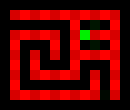

In [11]:
example = 10 #random.randrange(x_train.shape[0])

input_data = np.array([x_train[example]])


prediction = model.predict(input_data)

# print input data
input_data_print = x_train[example,:,:,0] * 100
input_data_print = input_data_print.astype(np.uint8)
print("input: ")
print(input_data_print)

# generate greyscale image data from input data
target_imgdata = x_train[example,:,:,0] * 255
target_imgdata = target_imgdata.astype(np.uint8)

# print prediction
prediction_data_print = prediction[0,:,:,1] * 100 
prediction_data_print = prediction_data_print.astype(np.uint8)
print("prediction: ")
print(prediction_data_print)

# generate greyscale image data from prediction data
prediction_imgdata = prediction[0] * 255
prediction_imgdata = prediction_imgdata.astype(np.uint8)

# merge image data in color channels
tmp = np.zeros((prediction[0].shape[0], prediction[0].shape[1]), dtype=np.uint8)
merged_imgdata = np.stack([target_imgdata, prediction_imgdata[:,:,1], tmp], axis=2)

#create image
img = Image.fromarray(merged_imgdata, 'RGB')
img = img.resize(size=(img.size[0]*10, img.size[1]*10))

img

## Export the model
Save the model. Export it with Keras's save method for use in the modelServer. The modelServer will provide the model's prediction function as a local Service for KSquares.

In [9]:
model_path = "model/model-firstTry.h5"
model_json = model.save(model_path)
img_path = "model/model-firstTry.png"
plot_model(model, to_file=img_path)

In [12]:
signature = tf.saved_model.signature_def_utils.predict_signature_def(
    inputs={'image': model.input}, 
    outputs={'scores': model.output})     

builder = tf.saved_model.builder.SavedModelBuilder('model/tensorflow')                                                                    
builder.add_meta_graph_and_variables(                                                                                                        
    sess=K.get_session(),                                                                                                                    
    tags=[tf.saved_model.tag_constants.SERVING],                                                                                             
    signature_def_map={                                                                                                                      
        tf.saved_model.signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY:                                                                
            signature                                                                                                                        
    })                                                                                                                                       
builder.save()

INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: model/tensorflow/saved_model.pb


'model/tensorflow/saved_model.pb'